In [1]:
import pandas as pd
from os.path import join, basename
from glob import glob
from scipy.stats import spearmanr
import numpy as np

from sklearn.metrics import mean_absolute_error
''''
hyperformer all
'''
#PATIENT_GROUP_LOCATION_IN_FILENAME = -3
#SUBKLINISCHE_GRUPPE = "Subklinische_Gruppe"
''''
    meta data and neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_meta_nt"
''''
hyperformer all
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt"


''''
hyperformer reapprasials
'''
PATIENT_GROUP_LOCATION_IN_FILENAME = -4
SUBKLINISCHE_GRUPPE = "SubklinischeGruppe"
''''
    meta data 
'''
RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/gpu1/"
BASELINE_FOLDER = "hyperformer++_reapprasial"
RESULT_FOLDER = "hyperformer++_reapprasial_meta_depression"
''''
hyperformer reapprasials
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_nt"
''''
hyperformer reapprasials
    meta data and neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_nt_many_hot"



"'\nhyperformer reapprasials\n    meta data and neutral texts \n"

In [2]:
def load_predictions(experiment, patient_groups=None, result_base_adjusted=None):
    predictions = {}
    if result_base_adjusted is None: 
        current_result_base = RESULTS_BASE 
    else: 
        current_result_base = result_base_adjusted
    fold_dirs = glob(f"{current_result_base}/{experiment}/*/")
    for fold_dir in fold_dirs:
        try:
            fold = int(fold_dir.split("/")[-2])
            fold_predictions = list(glob(f"{fold_dir}/predictions.test.csv"))[0]
            _predictions = parse_filename(pd.read_csv(fold_predictions))
            if patient_groups is not None:
                _predictions = _predictions[_predictions["patientGroup"].isin(patient_groups)]
            if not "true" in _predictions.columns:
                _predictions["true"] = _predictions["selfRatingDepression"]
            predictions[fold] = _predictions
        except ValueError:
            print(f"{fold_dir} probably not a fold directory.")
    all_predictions = pd.concat(predictions.values())
    return predictions, all_predictions

def parse_filename(df):    
    #df["date"] = df["filename"].apply(lambda x: basename(x).split("_")[0])
    df["patientGroup"] = df["filename"].apply(lambda x: x.split("/")[PATIENT_GROUP_LOCATION_IN_FILENAME])
    df["ID"] = df["filename"].apply(lambda x: x.split("/")[PATIENT_GROUP_LOCATION_IN_FILENAME + 1])
   # df["Content"] = df["filename"].apply(lambda x: basename(x))
    return df

def session_mean(df):
    numeric_columns = ["true", "prediction"] 
    return df.groupby(["ID", "patientGroup"])[numeric_columns].mean().reset_index()

def compute_metrics(df, group_by=[]):
    
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    print(speaker_spearman)
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
    return speaker_spearman, grouped_speaker_spearman

     
def compute_metrics_2(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    mae = mean_absolute_error(df["true"], df["prediction"])
    
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
        grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
        return speaker_spearman, grouped_speaker_spearman, mae, grouped_mae
    else:
        return speaker_spearman, mae



In [17]:
predictions, all_predictions = load_predictions(BASELINE_FOLDER, result_base_adjusted=BASELINE_BASE)
all_predictions.to_csv(BASELINE_FOLDER + "_predictions.csv", index=False)

In [3]:
def print_metrics(metrics):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f} ({np.std(metrics[key]):.3f})"
    return metric_string + " \\\\"

def print_metrics_2(metrics, metrics_mae):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f}\(\pm\){np.std(metrics[key]):.3f} & {np.mean(metrics_mae[key]):.3f}\(\pm\){np.std(metrics_mae[key]):.3f}"
    return metric_string + " \\\\"
    
def general_metrics_2(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    metrics_mae = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        # predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho, mae, grouped_mae = compute_metrics_2(predictions, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        metrics_mae["All"].append(mae)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        for name, value in zip(grouped_mae.index, grouped_mae.values):
            metrics_mae[name].append(value)
    return metrics, metrics_mae

def general_metrics(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        
        speaker_rho, grouped_speaker_rho = compute_metrics(predictions, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        # predictions_mean = session_mean(predictions)
        # print(predictions_mean)
        # speaker_rho, grouped_speaker_rho = compute_metrics(predictions_mean, group_by=["patientGroup"])
        # metrics["All"].append(speaker_rho)
        # for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
        #     metrics[name].append(value)
    return metrics

def phrase_metrics(experiment):
    predictions_fold, predictions_all = load_predictions(experiment)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"] = []
            metrics["All"].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics

def type_metrics(experiment):
    predictions_fold, predictions_all = load_predictions(experiment)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        #predictions["Content"] = predictions["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke" if "positiverGedanke" in x else "Garbage")
        predictions = predictions.groupby(["ID", "date", "patientGroup"]).mean().reset_index()
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics
    

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_base/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_nt/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_embedding/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_nt_2/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_depression_tests_nt_embedding/runs/ probably not a fold directory.


/tmp/ipykernel_723703/2325870316.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_723703/2325870316.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_723703/2325870316.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/tmp/ipykernel_723703/2325870316.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  predictions_hyperformer_avg = predictions_for_avg[
/tmp/ipykernel_723703/23258

Tests
_____________________________
set()
0.49382790531241777 0.3908498348907237
0.480357162832832 0.4283544124067522
Mean diff: -0.01347074247958564 (0.16607183621659857)
______________________________
NT
_____________________________
set()
0.49382790531241777 0.3908498348907237
0.5005083601382306 0.39269048489188385
Mean diff: 0.006680454825812898 (0.12539206729726343)
______________________________
Embed
_____________________________
set()
0.49382790531241777 0.3908498348907237
0.5024911289403488 0.40401942009776687
Mean diff: 0.008663223627931127 (0.13091748754225788)
______________________________
Tests\&NT
_____________________________
set()
0.49382790531241777 0.3908498348907237
0.49208442141881775 0.4024424779617501
Mean diff: -0.0017434838935999194 (0.06865226741839851)
______________________________
Tests\&Embed
_____________________________
set()
0.49382790531241777 0.3908498348907237
0.505114207754201 0.40722185824403656
Mean diff: 0.01128630244178331 (0.08670283035901025)


/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid va

nan nan


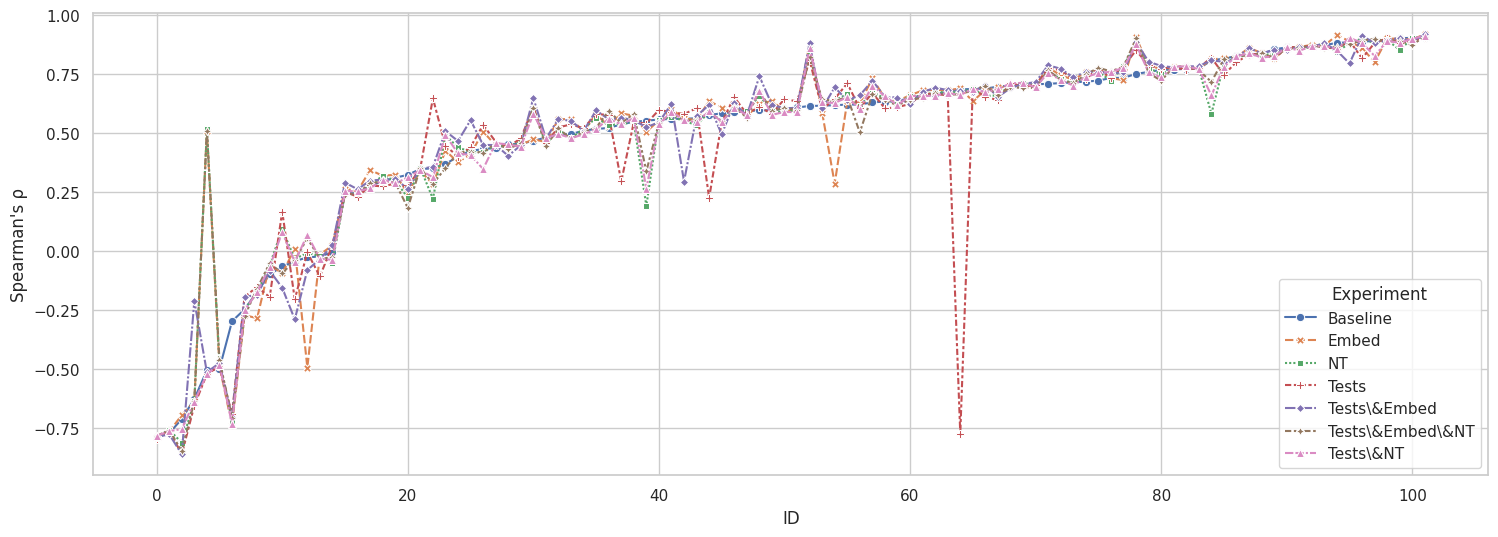

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]
configs = [
    
    
    ("Baseline", "hyperformer++_feedback_experiments_base", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("Tests", "hyperformer++_feedback_experiments_depression_tests", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("NT", "hyperformer++_reapprasial_nt", "/data/eihw-gpu2/pechleba/results/"),
    ("Embed", "hyperformer++_reapprasial_embedding", "/data/eihw-gpu2/pechleba/results/"),
    ("Tests\&NT", "hyperformer++_feedback_experiments_depression_tests_nt_2", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("Tests\&Embed", "hyperformer++_feedback_experiments_depression_tests_embeddings", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("Tests\&Embed\&NT", "hyperformer++_reapprasial_depression_tests_nt_embedding", "/data/eihw-gpu2/pechleba/results/"),
    
    # ("Hyperformer Reapprasial META", "hyperformer++_reapprasial_meta", BASELINE_BASE),
    # # ("Hyperformer PHQ-9", "hyperformer++_phq9"),
    # ("Hyperformer HAMD", "hyperformer++_hamd"),
    # ("Hyperformer BDI", "hyperformer++_bdi"),
    # ("Hyperformer Depression Tests", "hyperformer++_depression_tests"),
    # ("Hyperformer Demographics+Medication", "hyperformer++_demographics_medication"),
    # ("Hyperformer SEK", "hyperformer++_sek"),
    # ("Hyperformer Personality", "hyperformer++_personality"),
]
predictions_list = []
for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)
    # if "Hyperformer" in name:
    #     name = "Hyperformer"
    predictions["Experiment"] = name
    predictions_list.append(predictions)

predictions = pd.concat(predictions_list)
predictions = predictions[predictions.patientGroup.isin(groups)]


#predictions = (
#    predictions.groupby(["ID", "Experiment", "date", "patientGroup"])
#    .mean()
#    .reset_index()
#)
predictions = (
    predictions[["ID", "Experiment", "prediction", "true"]]
    .groupby(["ID", "Experiment"])
    .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
    .sort_values()
    .sort_index(level="Experiment", sort_remaining=False)
    .reset_index()
)

predictions_for_avg = predictions

predictions_for_avg.columns = ["ID", "Experiment", "Spearman's ρ"]
nan_rows = predictions_for_avg[predictions_for_avg["Spearman's ρ"].isna()]

predictions_for_avg = predictions_for_avg[~predictions_for_avg.index.isin(nan_rows.index)]

predictions_baseline_avg_ = predictions_for_avg[
    predictions_for_avg.Experiment == "Baseline"].sort_values(
    by="ID"
)

for name, path, result_base_adjusted in configs:
    if name != "Baseline":
        print(name)
        print("_____________________________")
        predictions_hyperformer_avg = predictions_for_avg[
            predictions.Experiment == name
        ].sort_values(by="ID")
        print(set(predictions_baseline_avg_["ID"]) - set(predictions_hyperformer_avg["ID"]))
        common_indices = predictions_baseline_avg_.index[predictions_baseline_avg_["ID"].isin(predictions_hyperformer_avg["ID"])]
        predictions_baseline_avg = predictions_baseline_avg_
        predictions_baseline_avg = predictions_baseline_avg.loc[common_indices]
        print(np.mean(predictions_baseline_avg["Spearman\'s ρ"].values), np.std(predictions_baseline_avg["Spearman\'s ρ"].values))
        print(np.mean(predictions_hyperformer_avg["Spearman\'s ρ"].values), np.std(predictions_hyperformer_avg["Spearman\'s ρ"].values))

        help = predictions_baseline_avg["Spearman's ρ"].values

        predictions_baseline_avg["Diff"] = (
            predictions_hyperformer_avg["Spearman's ρ"].values
            - help
        )

        print(
            f"Mean diff: {predictions_baseline_avg['Diff'].mean()} ({np.std(predictions_baseline_avg['Diff'])})"
        )
        print("______________________________")

# print((predictions["ID"].values))
print(len(set(predictions["ID"].values)))
predictions["ID"] = pd.factorize(predictions["ID"].values, sort=False)[0]

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ Base"
].sort_values(by="ID")

predictions.columns = ["ID", "Experiment", "Spearman's ρ"]
predictions_baseline = predictions[predictions.Experiment == "Baseline"].sort_values(
    by="ID"
)

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ adapter"
].sort_values(by="ID")



predictions_hyperformer.sort_values(by="Spearman's ρ").to_csv("name.csv", index=False)
sns.set_theme(style="whitegrid", rc={"figure.figsize": (18, 6)})
sns.lineplot(
    data=predictions,
    x="ID",
    y="Spearman's ρ",
    hue="Experiment",
    style="Experiment",
    markers=True,
)
predictions_hyperformer.columns = ["ID", "Experiment", "Spearman's ρ"]

nan_rows = predictions_hyperformer[predictions_hyperformer["Spearman's ρ"].isna()]

predictions_hyperformer = predictions_hyperformer[~predictions_hyperformer.index.isin(nan_rows.index)]

print(np.mean(predictions_hyperformer["Spearman\'s ρ"].values), np.std(predictions_hyperformer["Spearman\'s ρ"].values))


plt.savefig(f"speaker_performance_{RESULT_FOLDER.split('/')[-1]}_{'_'.join(groups)}.pdf")

In [8]:
table_contents = []
for name, path, result_base_adjusted in configs:
    m, mae = general_metrics_2(path, result_base_adjusted=result_base_adjusted)
    

    table_contents.append(f"{name} {print_metrics_2(m, mae)}")
print("\n".join(table_contents))


/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_base/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_b

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
/tmp/ipykernel_723703/1500348269.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the

/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_nt/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
/tmp/ipykernel_723703/1500348269.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the group

/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_embedding/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
/tmp/ipykernel_723703/1500348269.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolu

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_nt_2/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_b

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_embeddings/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
/tmp/ipykernel_723703/1500348269.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the group

/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_depression_tests_nt_embedding/runs/ probably not a fold directory.


/tmp/ipykernel_723703/1500348269.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_b

Baseline  & 0.498\(\pm\)0.083 & 1.385\(\pm\)0.190 & 0.642\(\pm\)0.088 & 0.937\(\pm\)0.253 & 0.368\(\pm\)0.180 & 2.221\(\pm\)0.561 & 0.539\(\pm\)0.087 & 1.081\(\pm\)0.155 \\
Tests  & 0.487\(\pm\)0.114 & 1.016\(\pm\)0.146 & 0.646\(\pm\)0.096 & 0.523\(\pm\)0.169 & 0.332\(\pm\)0.210 & 1.728\(\pm\)0.218 & 0.547\(\pm\)0.107 & 0.859\(\pm\)0.128 \\
NT  & 0.505\(\pm\)0.092 & 1.310\(\pm\)0.248 & 0.641\(\pm\)0.097 & 0.748\(\pm\)0.174 & 0.425\(\pm\)0.210 & 2.269\(\pm\)0.475 & 0.520\(\pm\)0.066 & 0.991\(\pm\)0.148 \\
Embed  & 0.508\(\pm\)0.098 & 1.489\(\pm\)0.221 & 0.641\(\pm\)0.097 & 0.793\(\pm\)0.265 & 0.416\(\pm\)0.199 & 2.555\(\pm\)0.421 & 0.542\(\pm\)0.093 & 1.216\(\pm\)0.213 \\
Tests\&NT  & 0.496\(\pm\)0.089 & 1.341\(\pm\)0.234 & 0.641\(\pm\)0.092 & 0.765\(\pm\)0.175 & 0.369\(\pm\)0.185 & 2.372\(\pm\)0.449 & 0.529\(\pm\)0.063 & 0.970\(\pm\)0.174 \\
Tests\&Embed  & 0.510\(\pm\)0.086 & 1.285\(\pm\)0.214 & 0.656\(\pm\)0.084 & 0.686\(\pm\)0.222 & 0.375\(\pm\)0.177 & 2.126\(\pm\)0.501 & 0.551\(\pm

/tmp/ipykernel_723703/1500348269.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_723703/1500348269.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_b

In [9]:

#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/fixed_merged_file.csv")

long_dfs = []
wide_df_2 = df.copy()
groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]



for j, (name, path, result_base_adjusted) in enumerate(configs):
    # _, predictions_hyperformer = load_predictions(path, result_base_adjusted=result_base_adjusted)
    folded_predictions, _ = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    num_values = ["true", "prediction"]
    for i, predictions_hyperformer in folded_predictions.items():
        predictions_hyperformer = (
            predictions_hyperformer.groupby(["ID", "patientGroup"])[num_values]
            .mean()
            .reset_index()
        )
        predictions_hyperformer = predictions_hyperformer[["ID", "prediction", "true"]]
        predictions_hyperformer_long = predictions_hyperformer.copy()
        predictions_hyperformer_long["Experiment"] = name
        predictions_hyperformer_long["fold"] = i
        long_dfs.append(predictions_hyperformer_long)
        if j == 0:
            predictions_hyperformer_long = predictions_hyperformer_long.copy()
            predictions_hyperformer_long["Experiment"] = "Groundtruth"
            predictions_hyperformer_long["prediction"] = predictions_hyperformer_long["true"]
            long_dfs.append(predictions_hyperformer_long)

    # predictions_hyperformer[name] = predictions_hyperformer[0]
    # wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")
long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")
print(long_df.columns)




/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_base/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_nt/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_embedding/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_nt_2/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_depression_tests_nt_embedding/runs/ probably not a fold directory.
Index(['ID', 'prediction', 'true', 'Experi

In [10]:
from scipy.stats import pearsonr
correlations_dict = {"Experiment": [], "PHQ": [], "HRSD": [], "SEK": [], "Groundtruth": []}

columns_mapping = {
    "PHQ": "t1_phq_sum",
    "HRSD": "t1_HAMD17_ges",
    "SEK": "t1_sek_sum",
    "Groundtruth": "true"
}

def spearman(data):
    d = {}
    for name, column in columns_mapping.items():
        d[name] = spearmanr(data["prediction"].values, data[column].values)[0]
    return pd.Series(d)

def mean_std_string(d):
    metric = f"{np.mean(d.values):.3f}"[1:]
    std = f"{np.std(d.values):.3f}"[1:]
    return f"$ {metric} \pm {std} $"

correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


for experiment in long_df["Experiment"].unique():
    
    _df = long_df[long_df.Experiment == experiment][["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]]
    _df.fillna(_df.mean(), inplace=True)
    correlations_dict["Experiment"].append(experiment)
    correlations_dict["PHQ"].append(spearmanr(_df["prediction"].values, _df["t1_phq_sum"].values)[0])
    correlations_dict["HRSD"].append(spearmanr(_df["prediction"].values, _df["t1_HAMD17_ges"].values)[0])
    correlations_dict["SEK"].append(spearmanr(_df["prediction"].values, _df["t1_sek_sum"].values)[0])
    correlations_dict["Groundtruth"].append(spearmanr(_df["prediction"].values, _df["true"].values)[0])
_df = long_df[long_df.Experiment == "Baseline"][["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]]
_df.fillna(_df.mean(), inplace=True)
correlations_dict["Experiment"].append("Groundtruth")
correlations_dict["PHQ"].append(spearmanr(_df["true"].values, _df["t1_phq_sum"].values)[0])
correlations_dict["HRSD"].append(spearmanr(_df["true"].values, _df["t1_HAMD17_ges"].values)[0])
correlations_dict["SEK"].append(spearmanr(_df["true"].values, _df["t1_sek_sum"].values)[0])
correlations_dict["Groundtruth"].append(spearmanr(_df["true"].values, _df["true"].values)[0])

print(correlations_table.to_latex(float_format="$%.6f$", escape=False))


/tmp/ipykernel_723703/3804038724.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


\begin{tabular}{lllll}
\toprule
 & PHQ & HRSD & SEK & Groundtruth \\
Experiment &  &  &  &  \\
\midrule
Baseline & $ .439 \pm .060 $ & $ .401 \pm .076 $ & $ 0.423 \pm .134 $ & $ .372 \pm .122 $ \\
Embed & $ .245 \pm .095 $ & $ .279 \pm .214 $ & $ 0.154 \pm .069 $ & $ .174 \pm .057 $ \\
Groundtruth & $ .653 \pm .077 $ & $ .578 \pm .172 $ & $ 0.574 \pm .040 $ & $ .000 \pm .000 $ \\
NT & $ .447 \pm .099 $ & $ .408 \pm .110 $ & $ 0.417 \pm .090 $ & $ .396 \pm .114 $ \\
Tests & $ .709 \pm .076 $ & $ .707 \pm .014 $ & $ 0.623 \pm .106 $ & $ .597 \pm .081 $ \\
Tests\&Embed & $ .494 \pm .084 $ & $ .492 \pm .082 $ & $ 0.433 \pm .085 $ & $ .420 \pm .091 $ \\
Tests\&Embed\&NT & $ .416 \pm .084 $ & $ .379 \pm .108 $ & $ 0.412 \pm .102 $ & $ .360 \pm .089 $ \\
Tests\&NT & $ .428 \pm .087 $ & $ .402 \pm .104 $ & $ 0.410 \pm .105 $ & $ .389 \pm .116 $ \\
\bottomrule
\end{tabular}



In [11]:
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
from scipy.interpolate import interp1d

# def gini(x):
#     # Mean absolute difference
#     
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     # Relative mean absolute difference
#     rmad = mad/np.mean(x)
#     # Gini coefficient
#     g = 0.5 * rmad
#     return g

def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    x = np.array([float(value) for value in x["Spearman"].values])
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    result = diffsum / (len(x)**2 * np.mean(x))
    return result.tolist()

def gini_2(v, n_new = 1000):
    """Compute Gini coefficient of array of values"""
    v = [float(value) for value in v["Spearman"].values]
    v = (v - np.min(v)) / (np.max(v) - np.min(v))
    v_abs = np.sort(np.abs(v))
    cumsum_v = np.cumsum(v_abs)
    n = len(v_abs)
    vals = np.concatenate([[0], cumsum_v/cumsum_v[-1]])
    x = np.linspace(0, 1, n+1)
    f = interp1d(x=x, y=vals, kind='previous')
    xnew = np.linspace(0, 1, n_new+1)
    dx_new = 1/(n_new)
    vals_new = f(xnew)
    return 1 - 2 * np.trapz(y=vals_new, x=xnew, dx=dx_new)


def calc_gini_index(rmse_values):
    # Sort the rmse_values
    
    rmse_values["Spearman"] = ( rmse_values["Spearman"] - np.min( rmse_values["Spearman"])) / (np.max( rmse_values["Spearman"]) - np.min( rmse_values["Spearman"]))
    rmse_value_help = [float(value) if value > 0 else 0 for value in rmse_values["Spearman"].values]
    numeric_rmse_values =  sorted(rmse_value_help)

    # Calculate the cumulative sums
    cum_values = np.cumsum(numeric_rmse_values)
    sum_values = cum_values[-1]
    cum_indices = np.cumsum(np.arange(1, len(rmse_values) + 1))

    # Calculate the area under the line of perfect equality
    area_equal = np.trapz(cum_indices, dx=1)

    # Calculate the area under the Lorenz curve
    area_lorenz = np.trapz(cum_values, dx=1)

    # Calculate the Gini index
    gini_index = (area_equal - area_lorenz) / area_equal

    return gini_index

def calc_improvements(baseline, new_predictions, offset=1e-6):
    diff = new_predictions["Spearman"].values.squeeze() - baseline["Spearman"].values.squeeze()
    baseline = baseline["Spearman"].values.squeeze()

    improved = diff > 0
    got_worse = diff < 0

    num_improved = np.sum(improved)
    num_got_worse = np.sum(got_worse)

    median_improvement = np.median(diff[improved] / (np.abs(baseline[improved]) + offset))
    median_loss = np.median(diff[got_worse] / (np.abs(baseline[got_worse]) + offset))
    median_improvement_percent = round((1 + median_improvement) * 100, 2)
    median_loss_percent = round(-median_loss * 100, 2)

    return num_improved.tolist(), num_got_worse.tolist(), median_improvement_percent, median_loss_percent
    
    
predictions_list = []
predictions_base =[]
predictions_adapters = {}


for name, path, result_base_adjusted in configs:

    # if name == "SpeechFormer++ Base":
    #     _, predictions_base = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    #     predictions_base = predictions_base[["ID", "true", "prediction"]]
    #     # rmse = predictions_base.groupby('ID').apply(lambda group: np.sqrt(mean_squared_error(group['true'], group['prediction'])))
    #     rmse = predictions_base.groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    #     predictions_base= rmse

    _, predictions_adapters[name] = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    # # predictions_adapters[name] = predictions_adapters[name][["ID", "true", "prediction"]]
    # # rmse = predictions_adapters[name].groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    # # predictions_adapters[name]= rmse

    # predictions_adapters[name] = predictions_adapters[name][(predictions_adapters[name]["patientGroup"].isin(["Patienten"]))]

    # predictions_adapters[name] = general_metrics(experiment=path, result_base_adjusted=result_base_adjusted)

    # SPEARMAN

    
    num_values = ["true", "prediction"]

    predictions_adapters[name] = (
        predictions_adapters[name][["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .sort_values()
        .sort_index(level="Experiment", sort_remaining=False)
        .reset_index()
    )

# predictions_base =  pd.DataFrame(predictions_base)
# predictions_adapters =  pd.DataFrame(predictions_adapters)

gini_index = {}
gini_winners_amount = {}
gini_winners_percent = {}
gini_losers_amount = {}
gini_losers_percent = {}

# Calculate the baseline Gini index
# predictions_base.columns = ["rmse"]
predictions_help = pd.DataFrame.from_dict(predictions_adapters["Baseline"])
# predictions_help.columns = [["rmse"]]
predictions_help.columns = [["ID", "Spearman"]]
predictions_baseline = predictions_help
# print(predictions_help)
baseline_gini_index= gini(predictions_help)
# print(f"Model: baseline\nGini Index: {gini_index['baseline']}")
for key in predictions_adapters.keys():
   
    predictions_help = pd.DataFrame.from_dict(predictions_adapters[key])
    # predictions_help.columns = [["rmse"]]
    # SPEARMAN
    predictions_help.columns = [["ID", "Spearman"]]
    
    # print(predictions_help)
    gini_index[key] = gini(predictions_help)
    # gini_index[key] = calc_gini_index(predictions_help)
    # gini_index[key] = gini_2(predictions_help)
    gini_winners_amount[key], gini_losers_amount[key],gini_winners_percent[key], gini_losers_percent[key] = calc_improvements(predictions_baseline, predictions_help)

    # Calculate the Gini coefficient relative to the baseline
    # gini_index[key] /= baseline_gini_index

    # print(f"Model: {key} Gini Index: {gini_index[key]}")
    # print(f"Model: {key} Winners Amount: {gini_winners_amount[key]}\nWinners Percent: {gini_winners_percent[key]}\nLosers Amount: {gini_losers_amount[key]}\nLosers Percent: {gini_losers_percent[key]}\n")


data = {
    "Model": list(gini_index.keys()),
    "Winners Amount": list(gini_winners_amount.values()),
    "Winners Percent": list(gini_winners_percent.values()),
    "Losers Amount": list(gini_losers_amount.values()),
    "Losers Percent": list(gini_losers_percent.values())
}

# Create DataFrame
df = pd.DataFrame(data)

df.fillna('--', inplace=True)

# Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=False)

print(latex_table)

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_base/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_nt/runs/ probably not a fold directory.


/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_embedding/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_nt_2/runs/ probably not a fold directory.


/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests_embeddings/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results//hyperformer++_reapprasial_depression_tests_nt_embedding/runs/ probably not a fold directory.
\begin{tabular}{lrlrl}
\toprule
Model & Winners Amount & Winners Percent & Losers Amount & Losers Percent \\
\midrule
Baseline & 0 & -- & 0 & -- \\
Tests & 17 & 104.980000 & 19 & 2.930000 \\
NT & 14 & 114.000000 & 21 & 1.340000 \\
Embed & 19 & 103.260000 & 18 & 2.910000 \\
Tests\&NT & 14 & 103.630000 & 21 & 3.240000 \\
Tests\&Embed & 18 & 105.170000 & 19 & 2.160000 \\
Tests\&Embed\&NT & 19 & 103.760000 & 18 & 2.780000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_723703/705832558.py:117: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_723703/705832558.py:172: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future v

In [ ]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

NameError: name 'long_df' is not defined

In [11]:
import pyreadstat
#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/merged_file_fixed_hyper.csv")

long_dfs = []
wide_df = df.copy()

configs = [
        
    ("Baseline", "hyperformer++_feedback_experiments_base", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("Tests", "hyperformer++_feedback_experiments_depression_tests", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("NT", "hyperformer++_feedback_experiments_nt", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    #("Embeddings", "hyperformer++_reapprasial_depression", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("Tests\&Embeddings", "hyperformer++_feedback_experiments_depression_tests_embeddings", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    ("Tests\&NT", "hyperformer++_feedback_experiments_depression_tests_nt_2", "/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment/"),
    
   # ("Hyperformer PHQ-9", "hyperformer++_phq9"),
   # ("Hyperformer HAMD", "hyperformer++_hamd"),
   # ("Hyperformer BDI", "hyperformer++_bdi"),
   # ("Hyperformer Depression Tests", "hyperformer++_depression_tests"),
   # ("Hyperformer Demographics+Medication", "hyperformer++_demographics_medication"),
   # ("Hyperformer SEK", "hyperformer++_sek"),
   # ("Hyperformer Personality", "hyperformer++_personality"),
]
for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)
    # if "Hyperformer" in name:
    #     name = "Hyperformer"

#predictions = (
#    predictions.groupby(["ID", "Experiment", "date", "patientGroup"])
#    .mean()
#    .reset_index()
#)
    predictions_hyperformer = (
        predictions[["ID","prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .dropna()
        .sort_values()
        .reset_index()
    )

    predictions_hyperformer_long = predictions_hyperformer.copy()
    predictions_hyperformer_long["Experiment"] = name
    long_dfs.append(predictions_hyperformer_long)
    # predictions_hyperformer[name] = predictions_hyperformer[0]
    predictions_hyperformer[name] = predictions_hyperformer[0]
    wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="subject")

long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="subject")
long_df["Spearman"] = long_df[0]

/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_base/runs/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/hyperformer_feedback_experiment//hyperformer++_feedback_experiments_depression_tests/runs/ probably not a fold directory.


/tmp/ipykernel_92402/3321583411.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92402/3321583411.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92402/3321583411.py:37: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92402/3321583411.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p

ValueError: No objects to concatenate

In [56]:
correlations = wide_df.corr(method="spearman")

/tmp/ipykernel_1495819/2743425926.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = wide_df.corr(method="spearman")


In [50]:
long_df

,ID,0,Experiment,subject,group,t1_datum,t1_state_01,t1_state_02,t1_state_03,t1_state_04,...,f4_median,nsyll,npause,dur(s),phonationtime(s),speechrate(nsyll / dur),articulation rate(nsyll / phonationtime),ASD(speakingtime / nsyll),subject.1,Spearman
0,BR0566,-0.785014,Baseline,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.625000,110.496,4.436847,5.285259,0.189205,NaN,-0.785014
1,BR0566,-0.793050,Tests,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.625000,110.496,4.436847,5.285259,0.189205,NaN,-0.793050
2,BR0566,-0.786725,Tests\&Embeddings,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.625000,110.496,4.436847,5.285259,0.189205,NaN,-0.786725
3,BR0566,-0.781517,Tests\&NT,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.625000,110.496,4.436847,5.285259,0.189205,NaN,-0.781517
4,BR0566,-0.783303,NT,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.625000,110.496,4.436847,5.285259,0.189205,NaN,-0.783303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,TJ1263,NaN,Baseline,TJ1263,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3630.019345,536,36,146.533562,112.896,3.657865,4.747732,0.210627,NaN,NaN
683,TJ1263,NaN,Tests,TJ1263,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3630.019345,536,36,146.533562,112.896,3.657865,4.747732,0.210627,NaN,NaN
684,TJ1263,NaN,Tests\&Embeddings,TJ1263,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3630.019345,536,36,146.533562,112.896,3.657865,4.747732,0.210627,NaN,NaN
685,TJ1263,NaN,Tests\&NT,TJ1263,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3630.019345,536,36,146.533562,112.896,3.657865,4.747732,0.210627,NaN,NaN


In [51]:
phq9_columns = ['t1_phq_1', 't1_phq_2', 't1_phq_3', 't1_phq_4', 't1_phq_5', 't1_phq_6', 't1_phq_7', 't1_phq_8', 't1_phq_9', 't1_phq_sum']
hamd_columns = ['t1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't1_HAMD17_ges']
sek_columns = ['t1_sek_1', 't1_sek_2', 't1_sek_3', 't1_sek_4', 't1_sek_5', 't1_sek_6', 't1_sek_7', 't1_sek_8', 't1_sek_9', 't1_sek_10', 't1_sek_11', 't1_sek_12', 't1_sek_13', 't1_sek_14', 't1_sek_15', 't1_sek_16', 't1_sek_17', 't1_sek_18', 't1_sek_19', 't1_sek_20', 't1_sek_21', 't1_sek_22', 't1_sek_23', 't1_sek_24', 't1_sek_25', 't1_sek_26', 't1_sek_27']
sums = ["t1_sek_sum", "t1_phq_sum", "t1_HAMD17_ges", "group"]

In [57]:
print(correlations[sums].loc[[x[0] for x in configs]].to_latex())
# Compute correlation between sek and std of mood ratings

\begin{tabular}{lrrrr}
\toprule
{} &  t1\_sek\_sum &  t1\_phq\_sum &  t1\_HAMD17\_ges &     group \\
\midrule
Baseline          &    0.158472 &   -0.172924 &      -0.130585 & -0.225461 \\
Tests             &    0.148828 &   -0.165324 &      -0.134429 & -0.223230 \\
Tests\textbackslash \&Embeddings &    0.143547 &   -0.149280 &      -0.110248 & -0.197064 \\
Tests\textbackslash \&NT         &    0.132048 &   -0.136658 &      -0.092859 & -0.177188 \\
NT                &    0.130560 &   -0.131363 &      -0.088887 & -0.181994 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1495819/2292493842.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(correlations[sums].loc[[x[0] for x in configs]].to_latex())


In [13]:
print(list(correlations.columns))

[0, 'NT', '0_x', 'Tests\\&NT', '0_y', 'Tests\\&Embeddings', '0_x', 'Tests', '0_y', 'Baseline', 'group', 't1_state_01', 't1_state_03', 't1_state_05', 't1_state_07', 't1_state_08', 't1_state_09', 't1_state_10', 't1_state_11', 't1_state_12', 't1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't2_state_01', 't2_state_03', 't2_state_05', 't2_state_07', 't2_state_08', 't2_state_09', 't2_state_10', 't2_state_11', 't2_state_12', 't2_HAMD_01', 't2_HAMD_02', 't2_HAMD_03', 't2_HAMD_04', 't2_HAMD_05', 't2_HAMD_06', 't2_HAMD_07', 't2_HAMD_08', 't2_HAMD_09', 't2_HAMD_10', 't2_HAMD_11', 't2_HAMD_12', 't2_HAMD_13', 't2_HAMD_14', 't2_HAMD_15', 't2_HAMD_16', 't2_HAMD_17', 't2_HAMD_18', 't2_HAMD_19', 't2_HAMD_20', 't2_HAMD_2

In [14]:
df["t1_HAMD24_ges"] = df[list(filter(lambda x: "t1_HAMD" in x, list(df.columns)))].apply(lambda x: sum(x), axis=1)

In [15]:
df[["Code", "t1_HAMD17_ges"]].sort_values(by="t1_HAMD17_ges").to_csv("hamd17.csv", index=False)